In [2]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
from datetime import date
from dateutil.relativedelta import relativedelta

from scipy import stats 
from scipy.stats import bootstrap
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
from scipy.stats import chi2_contingency
from statsmodels.graphics.mosaicplot import mosaic

--------------------------A/B testing analysis--------------------------------------------------------------------------------------------------

In [10]:
# data
task_2 = pd.read_csv('~/uploaded_docs/Проект_1_Задание_2.csv',sep = ';')
task_2control = task_2.query('testgroup == "a"').copy()
task_2test = task_2.query('testgroup == "b"').copy()
print(task_2control.head())
print(task_2test.head())

    user_id  revenue testgroup
1         2        0         a
2         3        0         a
9        10        0         a
10       11        0         a
11       12        0         a
   user_id  revenue testgroup
0        1        0         b
3        4        0         b
4        5        0         b
5        6        0         b
6        7        0         b


In [11]:
print('control: ' ,task_2control.nunique())
print(task_2control.shape)
print("test: " ,task_2test.nunique())
print(task_2test.shape)

control:  user_id      202103
revenue         269
testgroup         1
dtype: int64
(202103, 3)
test:  user_id      202667
revenue        1209
testgroup         1
dtype: int64
(202667, 3)


In [12]:
print(task_2control.revenue.sum() / 202103)
print(task_2test.revenue.sum() / 202667)

25.413719736965806
26.75128659327863


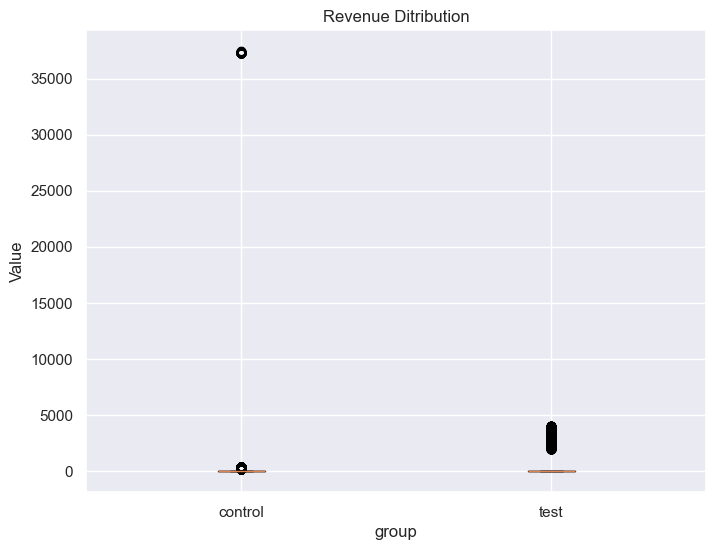

In [33]:
plt.figure(figsize=(8, 6))
plt.boxplot([task_2control['revenue'], task_2test['revenue']], labels=['control', 'test'])
plt.xlabel('group')
plt.ylabel('Value')
plt.title('Revenue Ditribution')

plt.savefig("revenue_distribution.png")
plt.grid(True)
plt.show()

the two groups are not evenly divided, which casts doubt on the success of the splitting, we need to check whether a/a testing was done 
a/a testing and what the result was, whether the a/a test was conducted fairly, i.e. whether the waiting times were similar, etc. 
in the appendix, whether the result gave significant differences even then.

For a complete answer, we need to understand which metric needs improvement, 
create a hypothesis that some action will produce a result on a certain metric. The assignment claims that arpu 
 in the test group is higher than in the control group.
Since I'm assuming a freemium application model, the main metric for this kind of application is 
like conversion, but since we're testing and want to increase arpu, the key metric 
is ARPU/ARPPU, and the PROXY metrics are CONVERSION RATE, RETENTION RATE.

NULL HYPOTHESIS: There is no difference in effect between players who received the test set of promotional offers
and those who received the regular set of promotional offers

In [14]:
# averages
print(task_2control.revenue.mean())
print(task_2test.revenue.mean())

25.413719736965806
26.75128659327863


In [15]:
# conversion to paying users
num_pay_users_a = task_2control.query('revenue > 0')['user_id'].nunique()
num_pay_users_b = task_2test.query('revenue > 0')['user_id'].nunique()
conv_a = (num_pay_users_a / task_2control.user_id.nunique()) * 100
conv_b = (num_pay_users_b / task_2test.user_id.nunique()) * 100
print(num_pay_users_a)
print(num_pay_users_b)
print(conv_a)
print(conv_b)

1928
1805
0.9539690157988748
0.8906235351586593


In [16]:
print('control', task_2control.revenue.sum())
print('test', task_2test.revenue.sum())

control 5136189
test 5421603


there is a difference between the groups in conversion and average, but we need to understand what are the PRACTICALLY SIGNIFICANT and 
STATISTICALLY SIGNIFICANT differences
We have to figure out which change is going to be beneficial.
For example, let's say that for a company a change in the average of three rubles or more is practically significant 
(costs will cover the gains from the change) when we get an average of about 28 or more. 
I will choose 5% as the statistical level of significance as it is in my opinion the most optimal, but it can be changed depending on the request.
change depending on the request.

## ARPU/ARPPU metric analysis



To compare the averages of the two groups, we need a t-test. 
To perform a t-test, samples must meet these requirements 
1. Normality of the data distribution , but according to the t-test, if the sample size is large enough, the distribution of the averages will tend toward normality, even if the data itself is not normal. This allows the t-test to be used for large samples.
2. Homoscedasticity 
3. independence of observations
4. Sample size
5. Representativeness of the sample

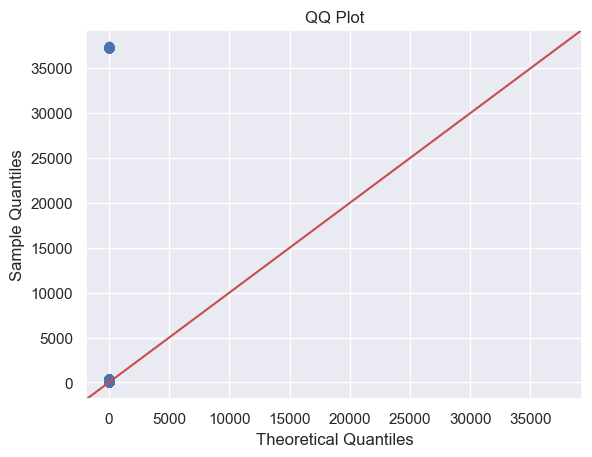

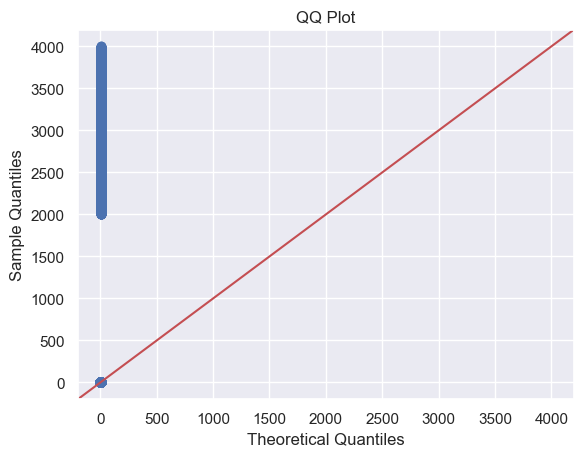

In [20]:
# run a qq plot to see how our data is distributed
sm.qqplot(task_2control['revenue'], line='45')
plt.title('QQ Plot')
plt.show()


sm.qqplot(task_2test['revenue'], line='45')
plt.title('QQ Plot')
plt.show()

data is not normally distributed

In [21]:
# logarithmize columns to smooth absolute values, making differences between two groups 
# more linear and easier to detect by statistical tests
task_2test['logs'] = np.log(task_2test['revenue'] + 1) 
task_2control['logs'] = np.log(task_2control['revenue'] + 1)

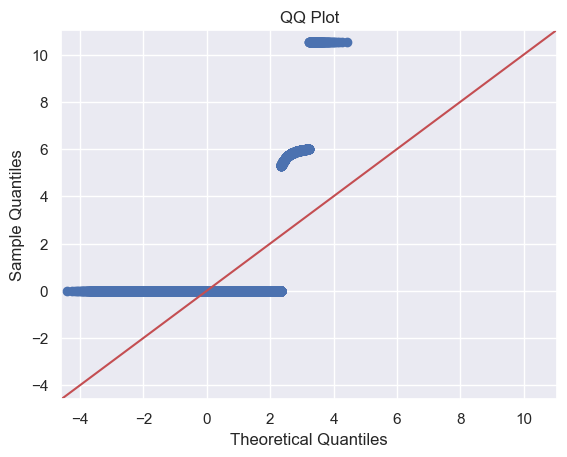

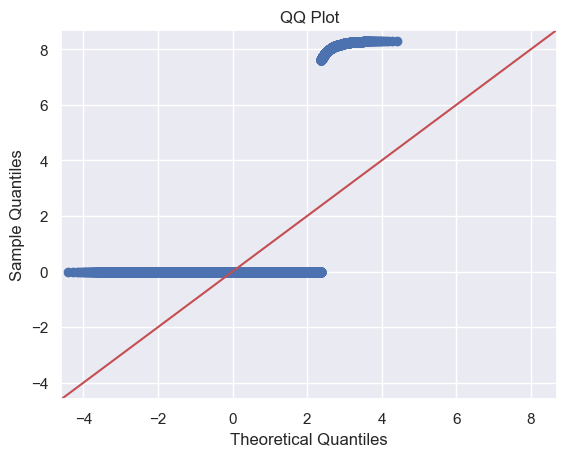

In [22]:
# let's see 
sm.qqplot(task_2control['logs'], line='45')
plt.title('QQ Plot')
plt.show()


sm.qqplot(task_2test['logs'], line='45')
plt.title('QQ Plot')
plt.show()

In [ ]:
# perform Levene's test for equality of variance 
stat, p_value = stats.levene(task_2control['logs'], task_2test['logs'])

The samples are non-normally distributed, the variance of the samples is not equal, all observations are independent of each other, the sample size is larger than 30 observations (suitable for the t-test) and assuming that the representativeness of the sample meets the requirements, I use a modification of the t-test called Welch's t-test, which does not require equality of variance.

In [ ]:
# test for differences in mean values between two groups among players
stats.ttest_ind(task_2control['logs'], task_2test['logs'], equal_var=False)

In [ ]:
# test for differences in mean values between two groups among buyers 
stats.ttest_ind(task_2control.query('revenue > 0')['logs'],task_2test.query('revenue > 0')['logs'],equal_var=False)

In [ ]:
sns.set_theme(style="darkgrid")
sns.kdeplot(task_2control.query('revenue > 0')['logs'], fill=True, color="r")
sns.kdeplot(task_2test.query('revenue > 0')['logs'], fill=True, color="b")
plt.show()

## CONVERSION RATE metric analysis



For comparison of two categorical groups chi square test and Fisher's test are used, since the groups are large and do not consist of zero values I will use chi square test the use of which requires: 

1. The frequencies to be compared must be of approximately the same size
2. The groups to be compared must be independent (i.e., the units of observation in them are different, unlike linked groups analyzing “before-after” changes in the same units of observation before and after the intervention.

Samples are large and roughly equal, groups are independent - data fit the requirements 

In [35]:
# chi square table, and group conversion #
data = {'paid': [1928, 1805, 3733],
        'not_paid': [200175, 200862, 401037],
        'overall': [202103, 202664, 404770]}


chi_table = pd.DataFrame(data, index = ['control', 'test', 'overall'])


chi_table['conversion_rate'] = (chi_table['paid'] / chi_table['overall']) * 100
chi_table

,paid,not_paid,overall,conversion_rate
control,1928,200175,202103,0.953969
test,1805,200862,202664,0.890637
overall,3733,401037,404770,0.922252


In [36]:
lst = []
for i in task_2['revenue']:
    if i > 0:
        lst.append(1)
    else:
        lst.append(0)
task_2['paid'] = lst

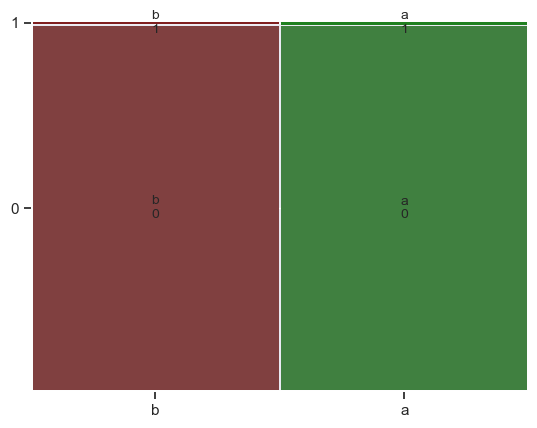

In [38]:
#mosaic for conversion 
mosaic(task_2, ['testgroup','paid'])
plt.savefig("mosaic.png")
plt.show()

In [ ]:
# the first column contains players who bought the product on promotion 
# the second column contains players who did not buy the promotional product 
# first row control group 
# second row test group 
observed = np.array([[1928, 200175], [1805, 200862]])
observed

In [ ]:
chi2, p_value, dof, expected = chi2_contingency(observed)

# Retention rate metric analysis

----------------------------------------------little bit of EDA -----------------------------------------

In [23]:
df1 = pd.read_csv('~/uploaded_docs/problem1-reg_data.csv', sep = ';')
df2 = pd.read_csv('~/uploaded_docs/problem1-auth_data.csv', sep = ';')

In [24]:
# translating from the eras 
df1['date'] = pd.to_datetime(df1['reg_ts'],unit = 's',utc = True ).dt.date
df2['date'] = pd.to_datetime(df2['auth_ts'],unit = 's',utc = True).dt.date
df1['date'] = pd.to_datetime(df1['date'])
df2['date'] = pd.to_datetime(df2['date'])

In [25]:
df = df2.merge(df1, how = 'left', on = 'uid')
df = df.rename(columns = {'date_x':'login_date', 'date_y':'reg_date'})
df = df.drop(columns = ['reg_ts','auth_ts'])
df 

,uid,login_date,reg_date
0,1,1998-11-18,1998-11-18
1,2,1999-07-22,1999-07-22
2,2,1999-07-25,1999-07-22
3,2,1999-07-31,1999-07-22
4,2,1999-08-05,1999-07-22
...,...,...,...
9601008,1110618,2020-09-23,2020-09-23
9601009,1110619,2020-09-23,2020-09-23
9601010,1110620,2020-09-23,2020-09-23
9601011,1110621,2020-09-23,2020-09-23


In [26]:
# little bit of EDA  
print(df1.dtypes,\
      df1.dtypes,\
      
      df1.shape,\
      df2.shape,\
      
      df2.uid.isnull().sum(),\
      df1.uid.isnull().sum(),\
      
      df1['date'].describe(),\
      df1['date'].describe(),\
    
      df1['date'].mean(),\
      df2['date'].mean(),
      )

reg_ts             int64
uid                int64
date      datetime64[ns]
dtype: object reg_ts             int64
uid                int64
date      datetime64[ns]
dtype: object (1000000, 3) (9601013, 3) 0 0 count                          1000000
mean     2019-01-24 00:12:37.209599232
min                1998-11-18 00:00:00
25%                2018-06-03 00:00:00
50%                2019-07-30 00:00:00
75%                2020-04-01 00:00:00
max                2020-09-23 00:00:00
Name: date, dtype: object count                          1000000
mean     2019-01-24 00:12:37.209599232
min                1998-11-18 00:00:00
25%                2018-06-03 00:00:00
50%                2019-07-30 00:00:00
75%                2020-04-01 00:00:00
max                2020-09-23 00:00:00
Name: date, dtype: object 2019-01-24 00:12:37.209599232 2019-01-29 04:12:09.041572096


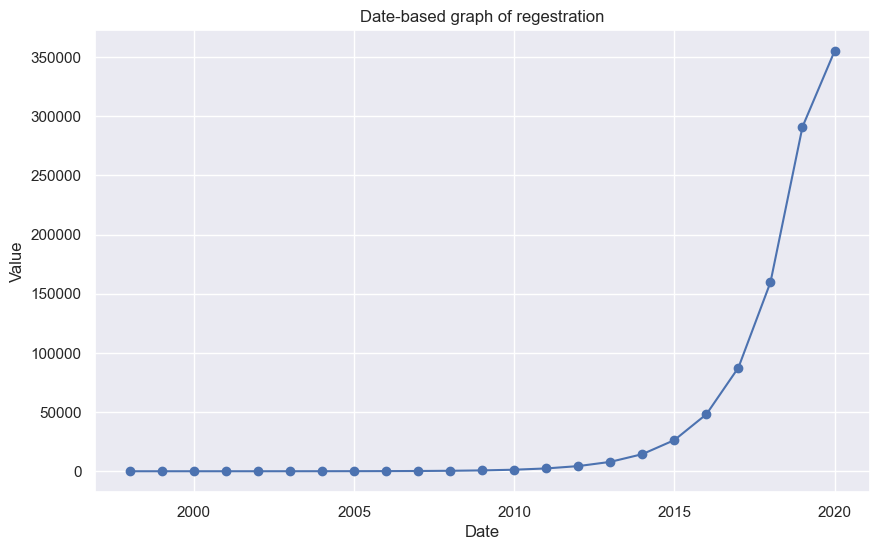

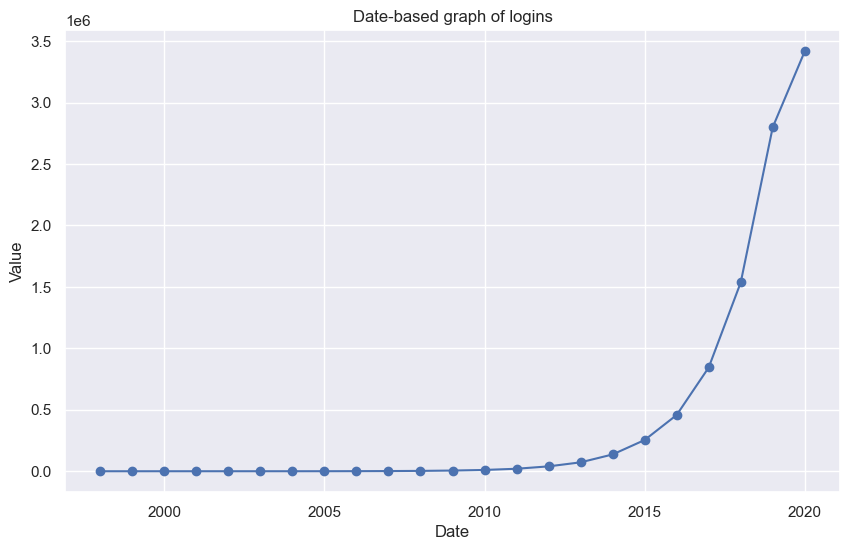

In [27]:
 # create a graph to get a complete picture of the structure
df1['year'] = (pd.to_datetime(df1['date']).dt.year)
years1 = df1.groupby('year').agg({'date':'count'})
df2['year'] = (pd.to_datetime(df2['date']).dt.year)
years2 = df2.groupby('year').agg({'date':'count'})

sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 6))
plt.plot(years1, marker='o', linestyle='-')
plt.title('Date-based graph of regestration')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(years2, marker='o', linestyle='-')
plt.title('Date-based graph of logins')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [39]:
def weekly_retention(dataframe, weeks_ret):
    '''
   The function returns retention tables with absolute and relative values.
    
        Parameters:
            dataframe (DataFrame) : dataframe 
            weeks_ret (int): number of weeks over which we want to analyze, assuming that 
            filtering will be performed from the end of the dataframe 
           
        Returns:
            retention_grouped (DataFrame): dataframe with absolute values
            retention_table_per (Dataframe): dataframe with relative values
            table with relative values with heatmap for easier understanding       
       '''
    
    last_weeks = dataframe['reg_date'].max() - relativedelta(weeks = weeks_ret)
    dataframe  = dataframe.loc[dataframe['reg_date'] > last_weeks].copy()
    
    
    dataframe['reg_date']   = pd.to_datetime(dataframe['reg_date'])
    dataframe['login_date'] = pd.to_datetime(dataframe['login_date'])
    dataframe['log_index']  = dataframe['login_date'] - pd.to_timedelta(dataframe['login_date'].dt.dayofweek, unit='D')
    dataframe['reg_date']   = dataframe['reg_date'] - pd.to_timedelta(dataframe['reg_date'].dt.dayofweek, unit='D')
    dataframe['login_diff']  = ((dataframe['log_index'] - dataframe['reg_date']) / pd.Timedelta(days=7)).astype(int)


    df                      = dataframe[['uid','reg_date', 'login_diff']]
    df                      = df.drop_duplicates(subset = ['uid','reg_date','login_diff'])
    retention_grouped       = df.groupby(['reg_date','login_diff']).size().unstack()
    retention_grouped       = retention_grouped.rename(columns = {'uid':'customer_count'})
    retention_table_per     = retention_grouped.divide(retention_grouped.iloc[:,0], axis = 0).round(2) 
    retention_table_per.index = retention_table_per.index.strftime('%d/%m/%Y')
    
    print('weekly retention table for {} weeks'.format(weeks_ret))
    print(retention_grouped)
    print('weekly percentile retention table for {} weeks'.format(weeks_ret))
    print(retention_table_per)
    
    
    fig,ax = plt.subplots(1,1,figsize = (16,10))
    sns.heatmap(retention_table_per, annot = True,vmin = 0,vmax = 0.25, fmt = '.1%', cbar = False, cmap = "YlGnBu")
    ax.set_xlabel('Cohort Index from last {} weeks'.format(weeks_ret))
    ax.set_ylabel('Cohort weeks')
    ax.xaxis.set_label_position('top')
    plt.show
    plt.savefig("weekly_retention.png")

weekly retention table for 6 weeks
login_diff        0       1       2       3       4      5      6
reg_date                                                         
2020-08-10   6163.0  1416.0  1242.0  1046.0   841.0  660.0  270.0
2020-08-17  10882.0  2586.0  2253.0  1896.0  1512.0  727.0    NaN
2020-08-24  11008.0  2491.0  2168.0  1775.0   850.0    NaN    NaN
2020-08-31  11136.0  2630.0  2268.0  1135.0     NaN    NaN    NaN
2020-09-07  11265.0  2620.0  1384.0     NaN     NaN    NaN    NaN
2020-09-14  11395.0  1461.0     NaN     NaN     NaN    NaN    NaN
2020-09-21   4327.0     NaN     NaN     NaN     NaN    NaN    NaN
weekly percentile retention table for 6 weeks
login_diff    0     1     2     3     4     5     6
reg_date                                           
10/08/2020  1.0  0.23  0.20  0.17  0.14  0.11  0.04
17/08/2020  1.0  0.24  0.21  0.17  0.14  0.07   NaN
24/08/2020  1.0  0.23  0.20  0.16  0.08   NaN   NaN
31/08/2020  1.0  0.24  0.20  0.10   NaN   NaN   NaN
07/09/2020  1

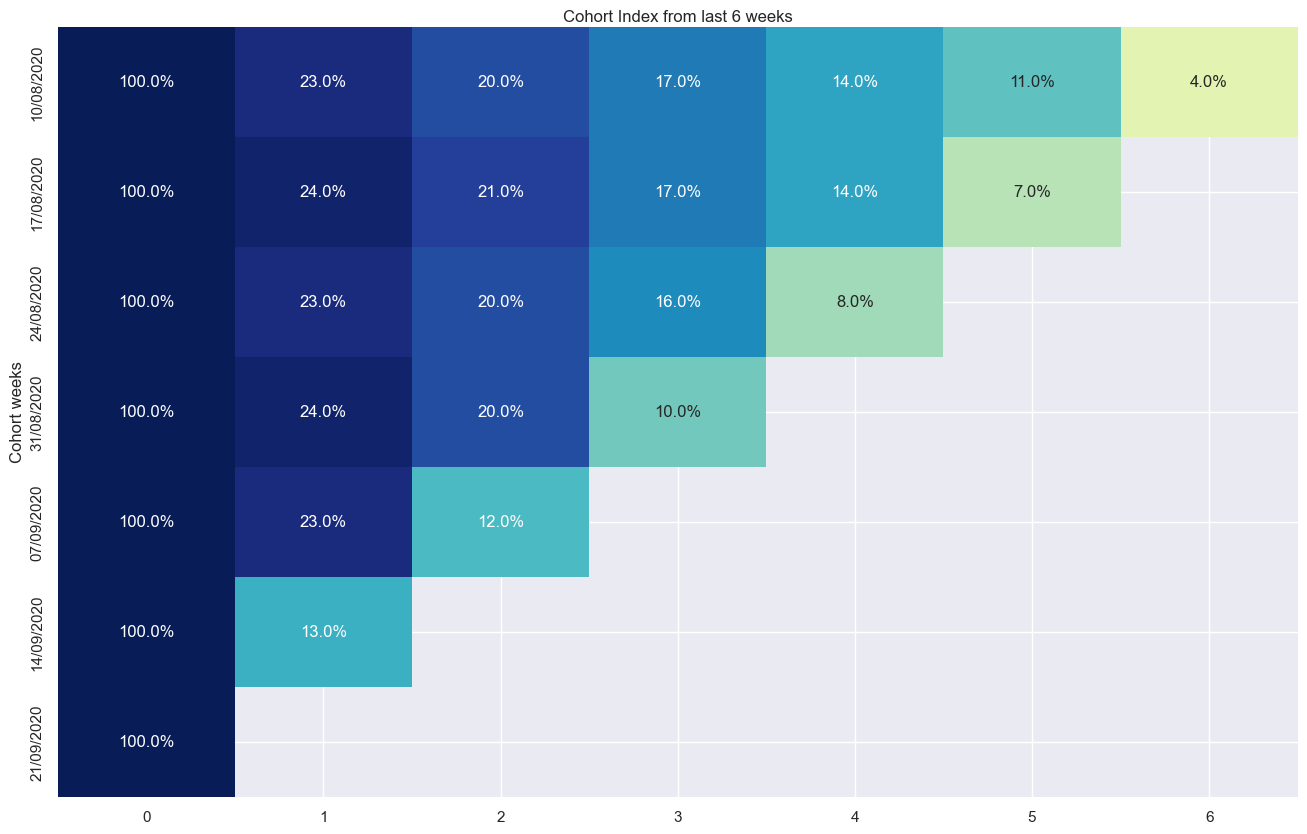

In [40]:
weekly_retention(df, 6)

* Based on the results of the t-test, I reject the hypothesis that there is no effect between players who received the test set of promotional offers and those who received the regular set of promotional offers. The control sample performed BETTER (in terms of ARPU/ARPPU) than the test sample. The statistic=-6.514242689960279 indicates that the mean in the first group is lower than the mean in the second group. The p_value=-7.415779070894375e-11 indicates that the differences between groups are statistically significant. 
* According to the results of chi square, p_value = 0.03647561892312613 which indicates that there are statistically significant differences in conversion between the test and control samples, and the test sample performed worse than the control sample.
* According to the results of retention rate I can see that almost half of the players dropped out. If the experiment took place from 2020-09-14 to 2020-09-21, the conclusion is that the retention of the test group is very low.

To make a decision from the beginning we need to be sure\
1. Why are there such large outliers in the data in the control sample?
2. We need to test the split system before the experiment.
3. We need to understand how the test version affected the metrics related to engagement, how engaged players were after purchase.

Conclusion: It is necessary to understand additional metrics, and looking at these metrics to refine the test version. Make some adjustments without affecting arpu/arppu. But at the moment, based on the results of two tests, the test variant has shown itself better, the conversion is slightly less, but arpu/arppu is noticeable. 

# Sales analysis


         The game features themed events every month, limited in time. In them, players can get unique items for characters, additional coins or bonuses. The rewards require completing a series of levels in a certain amount of time. What metrics can be used to evaluate the results of the most recent past event?

         Suppose, in another event, we have complicated the event mechanics so that every time the player fails to complete a level, the player will roll back a few levels. Would the set of outcome evaluation metrics change? If so, how?


For the first event, we need:
   - DAU is the number of active users during the day.
   - Session Frequency - the frequency of individual game sessions.
   - Duration - duration of game sessions
   - Level Conversion - percentage of players who have reached a certain level in relation to the total number of players.
   - Churn Rate - the percentage of users who have left the game
   - Retention - percentage of returning users
   - ARPU - average revenue per user.
\
\
For the second event:
   -  Retention Rate for Specific Levels - measures the percentage of users who successfully complete a specific level and then return to retain it for another time.
   -  level and then returned to complete it again within a certain amount of time.
   -  Average Time to Complete Level - The average time it takes users to complete a particular level. 
   -  Level Difficulty - the difficulty of a particular level in the game.
   -  User Satisfaction Level - the satisfaction of users from a certain level.
   -  Number of Attempts to Complete Level - the number of attempts users make to complete a particular level. 
   -  Churn Rate - The percentage of users who leave.
   -  Retention - percentage of returning users
   -  ARPU - Average Revenue Per User